In [ ]:
sample_size=30
from typing import List,Callable,Tuple
from statistics import mean,median,variance
import math
import random
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

#Computes Jackknife variance for a sample and given statistic
def jackknife_var(sample, statistic):
    n = len(sample)
    T_n = statistic(sample)

    pseudo = [0.0] * n
    for i in range(n):
        truncated = sample[:i] + sample[i+1:]
        pseudo[i] = n * T_n - (n - 1) * statistic(truncated)

    return variance(pseudo) / n
#Computes Bootstrap variance for a sample and given statistic
def bootstrap_var(sample:List[float],statistic: Callable[[List[float]],float])->float:
    bootstrap_l=1000
    boot_var=variance([statistic(random.choices(sample, k=len(sample))) for i in range(bootstrap_l)])
    return boot_var

#Computes actual_variance for a given statistic.
def actual_variance(statistic:Callable[[List[float]],float],distribution,Simulation_size:int=100000)->float:
    Variance=variance([statistic(distribution()) for i in range(Simulation_size)])
    return Variance

#Computes asymptotic_variance for a given statistic.
#def asymptotic_var(statistic:Callable)






In [3]:
class Distribution(ABC):
    def __init__(self, sample_size: int):
        self.sample_size = sample_size

    @abstractmethod
    def sample(self) -> List[float]:
        pass

    def __call__(self) -> List[float]:
        return self.sample()
    
class Normal01(Distribution):
    def __init__(self, sample_size: int):
        super().__init__(sample_size)
        self.name="Normal01"
    def sample(self) -> List[float]:
        return [
            random.gauss(0, 1)
            for _ in range(self.sample_size)
        ]
    
    def true_variance(self):
        return 1

class ChiSquare2(Distribution):
    def __init__(self, sample_size: int):
        super().__init__(sample_size)
        self.name="ChiSquare2"

    def sample(self) -> List[float]:
        return [
            random.gammavariate(2/ 2, 2)
            for _ in range(self.sample_size)
        ]
    
    def true_variance(self):
        return 4

In [4]:
class Statistic(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def statistic()->List[float]:
        pass

    def __call__(self,sample):
        return self.statistic(sample)
    
class Mean(Statistic):
    def __init__(self):
        self.name="Mean"

    def statistic(self,sample):
        return mean(sample)
    
    def asymptotic_var(self,distribution,sample_size):
        return distribution.true_variance()/sample_size
    
class Median(Statistic):
    def __init__(self):
        self.name="Median"

    def statistic(self,sample):
        return median(sample)
    
    def asymptotic_var(self,distribution,sample_size):
        if isinstance(distribution,Normal01):
            return math.pi/(2*sample_size)
        elif isinstance(distribution,ChiSquare2):
            return 4/sample_size
        else:
            raise NotImplementedError()



In [5]:
from tqdm import tqdm

def run_full_simulation(distribution, statistic, sample_size, simulation_size):
    generator = distribution(sample_size)   # distribution object
    stat = statistic()                       # statistic object

    Jackknife_var = [0.0] * simulation_size
    Bootstrap_var = [0.0] * simulation_size

    for i in tqdm(
        range(simulation_size),
        desc=f"{stat.name} | {generator.name} | n={sample_size}",
        leave=True
    ):
        sample = generator()
        Jackknife_var[i] = jackknife_var(sample, stat)
        Bootstrap_var[i] = bootstrap_var(sample, stat)

    True_var = actual_variance(stat, generator,10000)
    Asymptotic_var = stat.asymptotic_var(generator, sample_size)

    return {
        "Jackknife": Jackknife_var,
        "Bootstrap": Bootstrap_var,
        "True_Var": True_var,
        "Asymptotic_var": Asymptotic_var
    }

In [6]:
stats=dict()
for statistic in [Mean,Median]:
    stats[statistic().name]=dict()
    dist_dict=stats[statistic().name]
    for distribution in [Normal01,ChiSquare2]:
        dist_dict[distribution(10).name]=dict()
        sample_dict=dist_dict[distribution(10).name]
        for sample_size in [30,70,100]:
            sample_dict[sample_size]=run_full_simulation(distribution,statistic,sample_size,1000)

Mean | Normal01 | n=30: 100%|██████████| 1000/1000 [00:29<00:00, 34.26it/s]
Mean | Normal01 | n=70: 100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s]
Mean | Normal01 | n=100: 100%|██████████| 1000/1000 [01:05<00:00, 15.24it/s]
Mean | ChiSquare2 | n=30: 100%|██████████| 1000/1000 [00:28<00:00, 34.71it/s]
Mean | ChiSquare2 | n=70: 100%|██████████| 1000/1000 [00:50<00:00, 19.77it/s]
Mean | ChiSquare2 | n=100: 100%|██████████| 1000/1000 [01:05<00:00, 15.21it/s]
Median | Normal01 | n=30: 100%|██████████| 1000/1000 [00:04<00:00, 238.68it/s]
Median | Normal01 | n=70: 100%|██████████| 1000/1000 [00:09<00:00, 107.52it/s]
Median | Normal01 | n=100: 100%|██████████| 1000/1000 [00:13<00:00, 72.89it/s]
Median | ChiSquare2 | n=30: 100%|██████████| 1000/1000 [00:04<00:00, 240.68it/s]
Median | ChiSquare2 | n=70: 100%|██████████| 1000/1000 [00:09<00:00, 107.77it/s]
Median | ChiSquare2 | n=100: 100%|██████████| 1000/1000 [00:13<00:00, 73.39it/s]


In [17]:
import numpy as np
for stat in["Mean","Median"]:
    for dist in ["Normal01","ChiSquare2"]:
        for sample_size in [30,70,100]:
            stats[stat][dist][sample_size]["Jackknife efficiency"]=list(np.array(stats[stat][dist][sample_size]["Jackknife"])/stats[stat][dist][sample_size]["True_Var"])
            stats[stat][dist][sample_size]["Bootstrap efficiency"]=list(np.array(stats[stat][dist][sample_size]["Bootstrap"])/stats[stat][dist][sample_size]["True_Var"])

In [54]:
# -------------------------------------------------
# 2) Build efficiency comparison table
#    (median efficiency = robust & correct)
# -------------------------------------------------
rows = []
import pandas as pd


for stat in ["Mean", "Median"]:
    for dist in ["Normal01", "ChiSquare2"]:
        for sample_size in [30, 70, 100]:
            entry = stats[stat][dist][sample_size]

            rows.append({
                "Statistic": stat,
                "Distribution": dist,
                "Sample size": sample_size,
                "Jackknife efficiency": np.median(entry["Jackknife efficiency"]),
                "Bootstrap efficiency": np.median(entry["Bootstrap efficiency"]),
                "Asymptotic efficiency": entry["Asymptotic_var"] / entry["True_Var"],
            })

df = (
    pd.DataFrame(rows)
      .sort_values(["Statistic", "Distribution", "Sample size"])
      .round(3)
)

# -------------------------------------------------
# 3) Display table
# -------------------------------------------------
print(df)

# -------------------------------------------------
# 4) Optional: paper-ready wide format
# -------------------------------------------------
df_wide = df.pivot_table(
    index=["Statistic", "Distribution", "Sample size"],
    values=[
        "Jackknife efficiency",
        "Bootstrap efficiency",
        "Asymptotic efficiency",
    ]
)

print("\nWIDE FORMAT (paper-ready):\n")
print(df_wide)

# -------------------------------------------------
# 5) Optional exports
# -------------------------------------------------
# print(df.to_latex(index=False))      # LaTeX table
# df.to_csv("efficiency_table.csv", index=False)

# ===================== END =====================

   Statistic Distribution  Sample size  Jackknife efficiency  \
3       Mean   ChiSquare2           30                 0.883   
4       Mean   ChiSquare2           70                 0.964   
5       Mean   ChiSquare2          100                 1.002   
0       Mean     Normal01           30                 0.984   
1       Mean     Normal01           70                 0.972   
2       Mean     Normal01          100                 0.987   
9     Median   ChiSquare2           30                 0.425   
10    Median   ChiSquare2           70                 0.509   
11    Median   ChiSquare2          100                 0.510   
6     Median     Normal01           30                 0.577   
7     Median     Normal01           70                 0.478   
8     Median     Normal01          100                 0.467   

    Bootstrap efficiency  Asymptotic efficiency  
3                  0.854                  1.008  
4                  0.950                  1.009  
5                

In [65]:
import numpy as np
import pandas as pd

rows = []
latex_code=dict()
for stat in["Mean","Median"]:
    latex_code[stat]=dict()
    for dist in ["Normal01","ChiSquare2"]:
        rows = []
        for n in [ 30, 70, 100]:
            entry = stats[stat][dist][n]

            jk_eff = np.array(entry["Jackknife efficiency"])
            bs_eff = np.array(entry["Bootstrap efficiency"])
            asymp_eff = entry["Asymptotic_var"] / entry["True_Var"]

            rows.append({
                "n": n,
                "Jackknife Avg": jk_eff.mean(),
                "Jackknife SD": jk_eff.std(ddof=1),
                "Boot Avg": bs_eff.mean(),
                "Boot SD": bs_eff.std(ddof=1),
                "Asymp": asymp_eff
            })

        df_table4 = pd.DataFrame(rows).round(3)
        latex_code[stat][dist] = df_table4.to_latex(
        index=False,
        escape=False,
        caption=f"Performance for  Statistic in  Distribution",
        label=f"tab:_{stat}_{dist}",
        column_format="c c c c c c"
)
        print(f"Table 4: Performance for {stat} Statistic in {dist} Distribution\n")
        print(df_table4)

Table 4: Performance for Mean Statistic in Normal01 Distribution

     n  Jackknife Avg  Jackknife SD  Boot Avg  Boot SD  Asymp
0   30          0.996         0.253     0.966    0.250  1.004
1   70          0.984         0.171     0.971    0.176  0.983
2  100          0.997         0.145     0.988    0.152  0.999
Table 4: Performance for Mean Statistic in ChiSquare2 Distribution

     n  Jackknife Avg  Jackknife SD  Boot Avg  Boot SD  Asymp
0   30          0.987         0.483     0.954    0.472  1.008
1   70          1.015         0.351     1.003    0.351  1.009
2  100          1.036         0.288     1.026    0.289  1.023
Table 4: Performance for Median Statistic in Normal01 Distribution

     n  Jackknife Avg  Jackknife SD  Boot Avg  Boot SD  Asymp
0   30          2.112         4.735     1.185    0.676  1.048
1   70          2.135         4.925     1.091    0.524  1.023
2  100          1.849         3.513     1.091    0.479  0.998
Table 4: Performance for Median Statistic in ChiSquare

In [66]:
print(latex_code["Mean"]["ChiSquare2"])

\begin{table}
\caption{Performance for  Statistic in  Distribution}
\label{tab:_Mean_ChiSquare2}
\begin{tabular}{c c c c c c}
\toprule
n & Jackknife Avg & Jackknife SD & Boot Avg & Boot SD & Asymp \\
\midrule
30 & 0.987000 & 0.483000 & 0.954000 & 0.472000 & 1.008000 \\
70 & 1.015000 & 0.351000 & 1.003000 & 0.351000 & 1.009000 \\
100 & 1.036000 & 0.288000 & 1.026000 & 0.289000 & 1.023000 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
def plot_three_per_sample_size(
    result_dict,
    sample_sizes,
    title="",
    ylabel="Variance Ratio"
):
    # ---- layout parameters ----
    width = 0.2         # box width
    gap = 0.22         # separation between estimators
    positions = np.arange(len(sample_sizes))

    # ---- extract data ----
    jk_data = [result_dict[n]["Jackknife efficiency"] for n in sample_sizes]
    bs_data = [result_dict[n]["Bootstrap efficiency"] for n in sample_sizes]
    asymp_vals = [
        result_dict[n]["Asymptotic_var"] / result_dict[n]["True_Var"]
        for n in sample_sizes
    ]

    # ---- figure ----
    fig, ax = plt.subplots(figsize=(10, 5))

    # ---- jackknife boxplots ----
    bp1 = ax.boxplot(
        jk_data,
        positions=positions - gap,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

    # ---- bootstrap boxplots ----
    bp2 = ax.boxplot(
        bs_data,
        positions=positions,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

    # ---- styling ----
    for box in bp1["boxes"]:
        box.set(facecolor="#4C72B0", alpha=0.85)

    for box in bp2["boxes"]:
        box.set(facecolor="#DD8452", alpha=0.85)

    for med in bp1["medians"] + bp2["medians"]:
        med.set(color="black", linewidth=2)

    for whisker in bp1["whiskers"] + bp2["whiskers"]:
        whisker.set(linewidth=1.5)

    for cap in bp1["caps"] + bp2["caps"]:
        cap.set(linewidth=1.5)

    # ---- asymptotic reference lines ----
    for i, y in enumerate(asymp_vals):
        ax.hlines(
            y,
            positions[i]+0.5*gap ,
            positions[i] + 0.5*gap +width ,
            colors="black",
            linestyles="--",
            linewidth=2
        )

    # ---- axes & labels ----
    ax.set_xticks(positions)
    ax.set_xticklabels(sample_sizes)
    ax.set_xlabel("Sample size (n)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # ---- legend ----
    legend_elements = [
        Line2D([0], [0], color="#4C72B0", lw=6, label="Jackknife"),
        Line2D([0], [0], color="#DD8452", lw=6, label="Bootstrap"),
        Line2D([0], [0], color="black", lw=2, linestyle="--", label="Asymptotic")
    ]
    ax.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

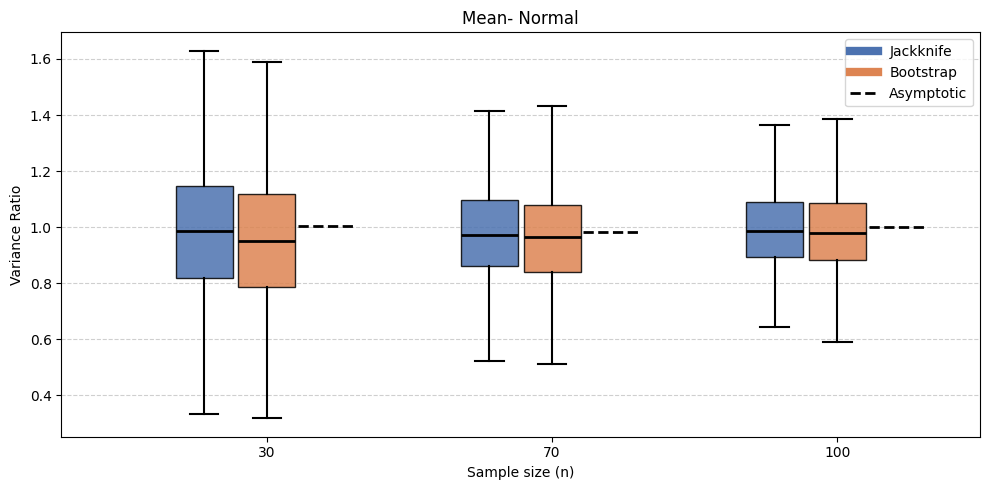

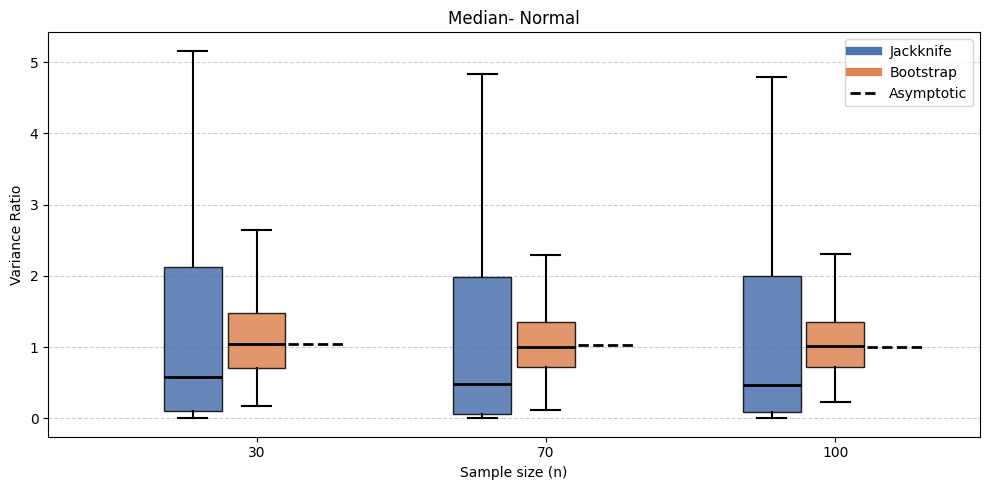

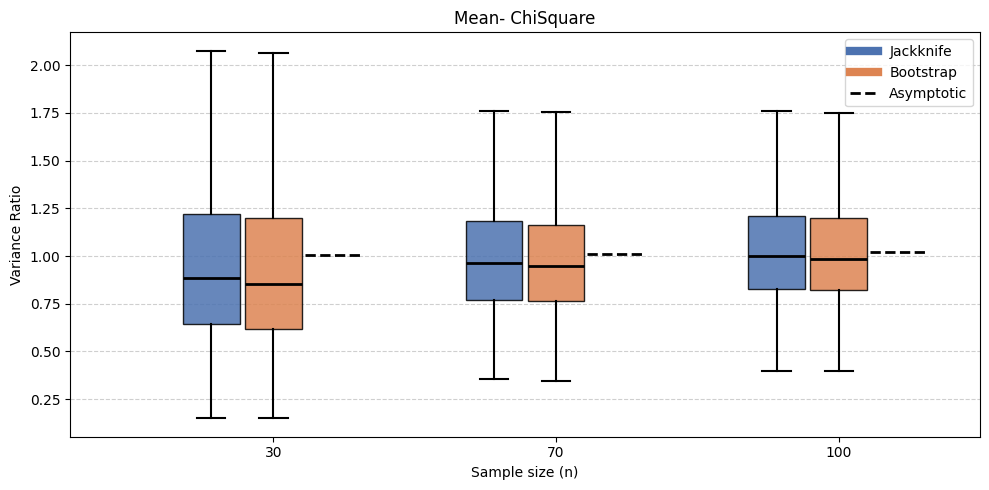

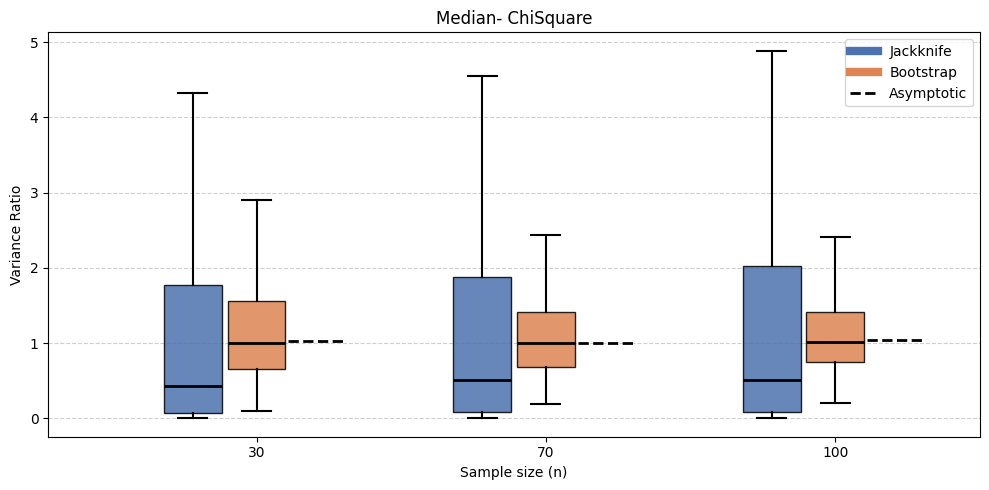

In [52]:
for i in [["Mean","Normal01","Mean- Normal"],["Median","Normal01","Median- Normal"],["Mean","ChiSquare2","Mean- ChiSquare"],
          ["Median","ChiSquare2","Median- ChiSquare"]]:
    plot_three_per_sample_size(stats[i[0]][i[1]],
                               sample_sizes=[30,70,100],
                               title=i[2])